# Supervised Regression on Rossmann Sales

This notebook implements supervised regression models on the Rossmann sales dataset. We start with a simple baseline, then train several regression models (linear, polynomial, Ridge, Random Forest) using the processed data from `Data/processed/train_clean.csv` and compare their performance.


## Imports and setup

We import common data science libraries (`pandas`, `numpy`, `matplotlib`, `seaborn`) for data handling and visualization, and scikit-learn tools for splitting the data, preprocessing features, building pipelines, and training regression models.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


## Load processed Rossmann training data

We load the cleaned and enriched training dataset `train_clean.csv` that was produced by the ETL pipeline. The `Date` column is parsed as a datetime so that we can easily derive calendar-based features (e.g. year, month, week of year) used later in the models.


In [26]:
PROJECT_ROOT = Path().resolve().parents[0] if len(Path().resolve().parents) > 1 else Path().resolve()
DATA_PROCESSED = PROJECT_ROOT / "Data" / "processed"

dtype_map = {"StateHoliday": "string", "PromoInterval": "string"}

train = pd.read_csv(DATA_PROCESSED / "train_clean.csv", dtype=dtype_map, parse_dates=["Date"])
print("Shape of training data:", train.shape)
train.head()


Shape of training data: (1017209, 26)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,State,LatMean,LonMean,OpenedSundayShare,AvgElevation,TotalPopulation,AvgDistanceHotel,AvgDistanceRail
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,<NA>,HE,50.426091,8.872172,0.050000,178.085714,2602613.0,4108.502671,6436.829953
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",TH,51.022708,11.175677,0.115385,259.634615,550608.0,7180.389299,10584.238587
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",NW,51.401387,7.334712,0.058968,107.083538,18415034.0,4394.972826,4424.111761
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,<NA>,BE,52.511819,13.402692,0.102804,46.953271,1748185.0,621.065978,1954.088654
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,<NA>,SN,51.033569,13.142509,0.045045,235.252252,1673534.0,5756.529620,7795.768223


## Feature engineering and feature selection

We define the supervised learning task as predicting daily `Sales` for each store. From the `Date` we create additional time features (year, month, day, week of year). We then select a set of numeric features (e.g. `Store`, `DayOfWeek`, `Promo`, competition and promo indicators, calendar features) and categorical features (e.g. `StateHoliday`, `StoreType`, `Assortment`, `State`) that are likely to influence sales.


In [27]:
# Feature engineering: date parts
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["Day"] = train["Date"].dt.day
train["WeekOfYear"] = train["Date"].dt.isocalendar().week.astype(int)

TARGET = "Sales"

numeric_features = [
    "Store",
    "DayOfWeek",
    "SchoolHoliday",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Year",
    "Month",
    "Day",
    "WeekOfYear",
]

categorical_features = [
    "StateHoliday",
    "StoreType",
    "Assortment",
    "State",
]

feature_cols = numeric_features + categorical_features

X = train[feature_cols].copy()
y = train[TARGET].values

X.head()


,Store,DayOfWeek,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Year,Month,Day,WeekOfYear,StoreType,Assortment,State
0,1,5,1270.0,9.0,2008.0,2015,7,31,31,c,a,HE
1,2,5,570.0,11.0,2007.0,2015,7,31,31,a,a,TH
2,3,5,14130.0,12.0,2006.0,2015,7,31,31,a,a,NW
3,4,5,620.0,9.0,2009.0,2015,7,31,31,c,c,BE
4,5,5,29910.0,4.0,2015.0,2015,7,31,31,a,a,SN


## Train/validation split

We split the data into training and validation sets (80/20). The models are fitted only on the training data and evaluated on the held-out validation data. This gives us an unbiased estimate of how well each model generalizes. For a true time-series forecasting setup we would use a time-based split, but here we follow the simpler random split as in the lecture example.


In [28]:
# Train/validation split (simple random split)
# Note: for true time-series forecasting, a time-based split would be more appropriate.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((813767, 12), (203442, 12))

## Preprocessing pipeline

Before training models we build a preprocessing pipeline. Numeric features are imputed (median) and scaled, while categorical features are imputed (most frequent value) and one-hot encoded. Using a `ColumnTransformer` inside a scikit-learn `Pipeline` ensures that the exact same preprocessing is applied during training and when making predictions, avoiding data leakage and keeping the workflow reproducible.


In [29]:
# Preprocessing: impute missing values, scale numeric features, one-hot encode categoricals
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Evaluation metrics and baseline model

To evaluate models we use three common regression metrics:
- **MAE (Mean Absolute Error)**: average absolute difference between predicted and true sales.
- **RMSE (Root Mean Squared Error)**: penalizes larger errors more strongly than MAE.
- **$R^2$ (coefficient of determination)**: proportion of variance in sales explained by the model.

As a simple baseline we always predict the mean `Sales` from the training set. Any useful model should significantly improve over this baseline.


In [30]:
def regression_metrics(y_true, y_pred, label="model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # older sklearn: no 'squared' argument
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MAE={mae:,.2f}, RMSE={rmse:,.2f}, R^2={r2:.4f}")


# Baseline model: predict mean of training Sales
baseline_pred = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
regression_metrics(y_test, baseline_pred, label="Baseline (mean)")


Baseline (mean): MAE=2,882.44, RMSE=3,845.62, R^2=-0.0000


## Linear regression model

We first fit a standard linear regression model, which assumes a linear relationship between the (preprocessed) features and `Sales`. This model is simple, interpretable, and provides a strong baseline to compare more complex models against.


In [31]:
# Linear regression model
linear_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
regression_metrics(y_test, y_pred_linear, label="Linear Regression")


Linear Regression: MAE=2,548.01, RMSE=3,303.00, R^2=0.2623


## Polynomial regression model

To capture non-linear relationships and interactions between features, we extend the linear model with polynomial features of degree 2. This allows the model to fit more complex patterns in the data, at the cost of higher risk of overfitting and increased computational cost.


In [32]:
# Polynomial regression (degree=2) on preprocessed features
poly_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("regressor", LinearRegression()),
    ]
)

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)
regression_metrics(y_test, y_pred_poly, label="Polynomial Regression (degree=2)")


Polynomial Regression (degree=2): MAE=2,208.03, RMSE=2,989.74, R^2=0.3956


## Diagnostic plots: true vs predicted

We visualize the relationship between true and predicted `Sales` for the linear and polynomial models. Points close to the diagonal line indicate good predictions. Systematic deviations from the diagonal can reveal underfitting, overfitting, or heteroscedasticity (errors growing with sales level).


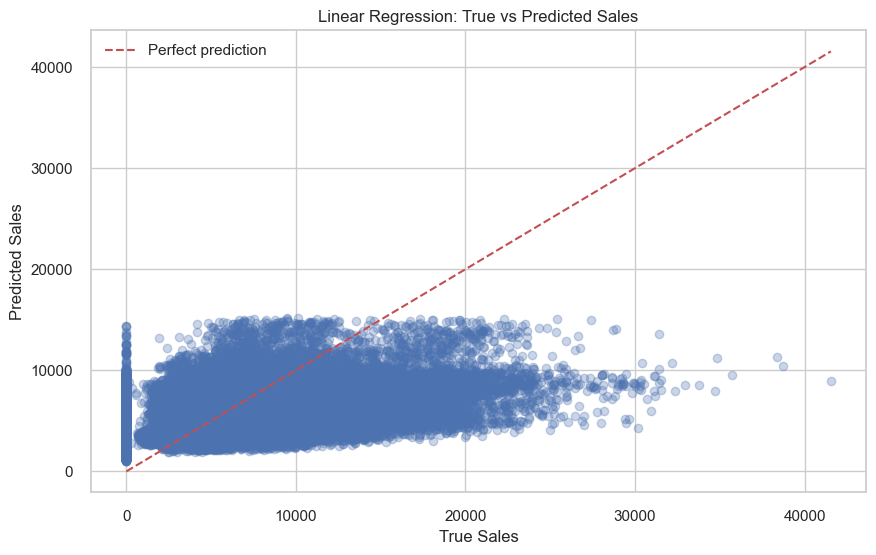

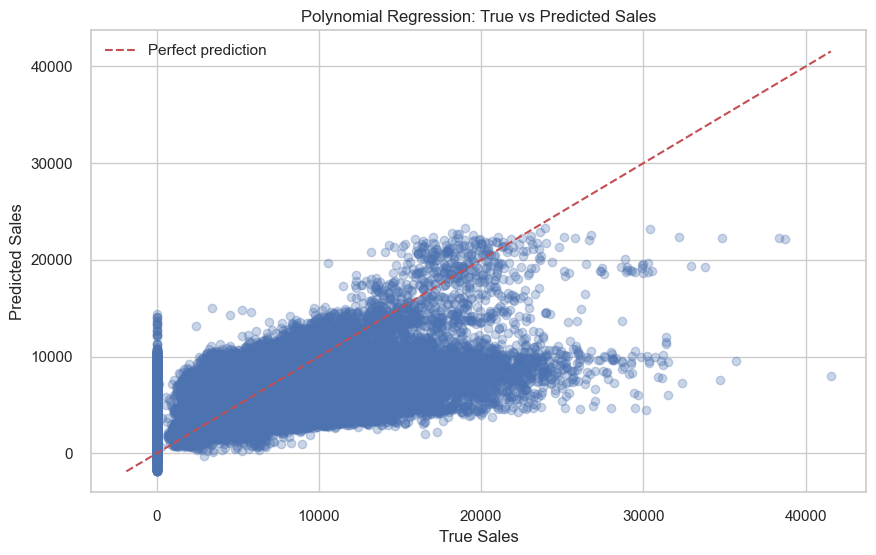

In [33]:
def plot_true_vs_pred(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.3)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    plt.xlabel("True Sales")
    plt.ylabel("Predicted Sales")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_true_vs_pred(y_test, y_pred_linear, "Linear Regression: True vs Predicted Sales")
plot_true_vs_pred(y_test, y_pred_poly, "Polynomial Regression: True vs Predicted Sales")


## Advanced models: Ridge and Random Forest

To go beyond plain linear and polynomial regression, we train two additional models:
- **Ridge regression**: a linear model with L2 regularization, which can reduce overfitting by shrinking coefficients and handling multicollinearity.
- **Random Forest Regressor**: an ensemble of decision trees that captures complex non-linear relationships and interactions without requiring explicit feature engineering.

We keep the hyperparameters relatively simple (e.g. `alpha=1.0` for Ridge, `n_estimators=100`, `max_depth=10` for Random Forest) to mirror the level of experimentation expected in the course.


In [34]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

models = {}

# Reuse baseline, linear, and polynomial predictions
models["Baseline (mean)"] = (y_test, baseline_pred)
models["Linear Regression"] = (y_test, y_pred_linear)
models["Polynomial (deg=2)"] = (y_test, y_pred_poly)

# Ridge regression
ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", Ridge(alpha=1.0)),
    ]
)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
models["Ridge (alpha=1.0)"] = (y_test, y_pred_ridge)

# Random Forest regression (simple configuration)
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
models["RandomForest (100, depth=10)"] = (y_test, y_pred_rf)

print("Trained advanced models: Ridge and RandomForest.")


Trained advanced models: Ridge and RandomForest.


## Metric comparison table

For each model (baseline, linear, polynomial, Ridge, Random Forest) we compute the same set of metrics (MAE, RMSE, $R^2$) on the validation set and collect them in a single table. This makes it easy to compare models quantitatively and justify which one performs best.


In [35]:
rows = []
for name, (yt, yp) in models.items():
    mae = mean_absolute_error(yt, yp)
    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    r2 = r2_score(yt, yp)
    rows.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

results_df = pd.DataFrame(rows).sort_values("RMSE")
results_df


,Model,MAE,RMSE,R2
4,"RandomForest (100, depth=10)",1685.820833,2471.485101,0.586969
2,Polynomial (deg=2),2208.025568,2989.740382,0.395587
1,Linear Regression,2548.014534,3303.003149,0.262291
3,Ridge (alpha=1.0),2548.014212,3303.003337,0.262291
0,Baseline (mean),2882.435814,3845.622790,-0.000001


## Model comparison plot

Finally, we plot the RMSE of each model as a bar chart. Lower RMSE means better predictive performance. This visualization is useful for the presentation to clearly communicate which supervised model works best for the Rossmann sales prediction task.


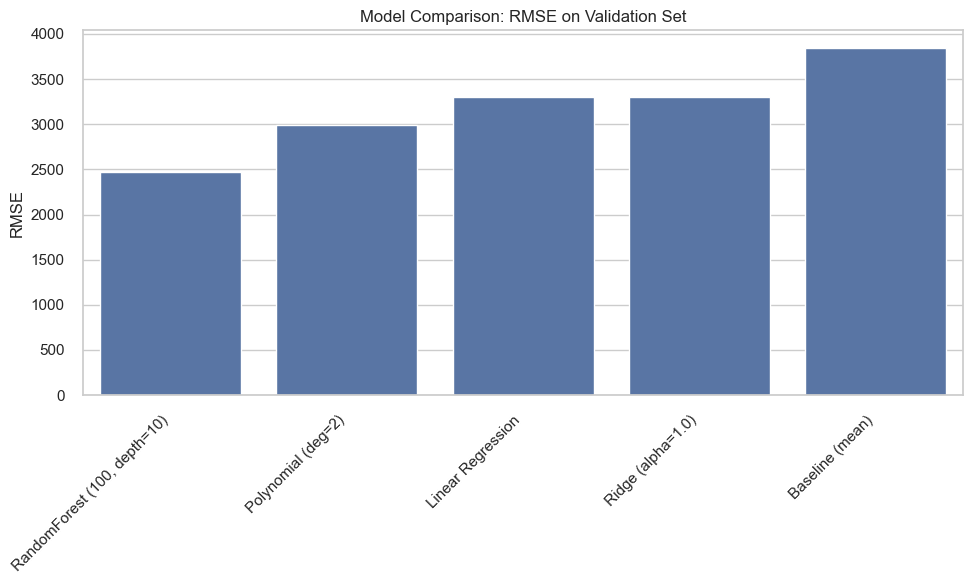

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison: RMSE on Validation Set")
plt.ylabel("RMSE")
plt.xlabel("")
plt.tight_layout()
plt.show()
